In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import train_test_split

# Auxiliary functions 

In [187]:
def plot_normal_fit(data, title_prefix, ax_hist, ax_qq):
    """
    Fit normal distribution and plot histogram + QQ plot
    Returns: mu_mle, sigma_mle
    """
    mu_mle, sigma_mle = st.norm.fit(data)

    # Histogram with fit
    sns.histplot(data, kde=False, stat='density', bins='auto', ax=ax_hist)
    x = np.linspace(min(data), max(data), 100)
    ax_hist.plot(x, st.norm.pdf(x, mu_mle, sigma_mle), 'r', label='Normal Fit (MLE)')
    ax_hist.legend()
    ax_hist.set_title(f'{title_prefix} - MLE Fit: μ={mu_mle:.2f}, σ={sigma_mle:.2f}')

    # QQ Plot
    st.probplot(data, dist=st.norm, sparams=(mu_mle, sigma_mle), plot=ax_qq)
    ax_qq.set_title(f'QQ Plot - Normal Fit {title_prefix}')

    return mu_mle, sigma_mle

def fit_gamma_mle(data):
    """
    Fit gamma distribution using MLE
    Returns: shape_mle, loc_mle, scale_mle, rate_mle
    """
    shape_mle, loc_mle, scale_mle = st.gamma.fit(data, floc=0)
    rate_mle = 1 / scale_mle
    return shape_mle, loc_mle, scale_mle, rate_mle

def plot_gamma_fit(data, title_prefix, ax_hist, ax_qq):
    """
    Fit gamma distribution and plot histogram + QQ plot
    Returns: shape_mle, loc_mle, scale_mle, rate_mle
    """
    shape_mle, loc_mle, scale_mle, rate_mle = fit_gamma_mle(data)

    # Histogram with fit
    sns.histplot(data, kde=False, stat='density', bins='auto', ax=ax_hist)
    x = np.linspace(min(data), max(data), 100)
    ax_hist.plot(x, st.gamma.pdf(x, shape_mle, loc=loc_mle, scale=scale_mle),
                 'r', label='Gamma Fit (MLE)')
    ax_hist.legend()
    ax_hist.set_title(f'Gamma Fit (MLE) {title_prefix}: k={shape_mle:.2f}, rate={rate_mle:.2f}')

    # QQ Plot
    st.probplot(data, dist=st.gamma, sparams=(shape_mle, loc_mle, scale_mle), plot=ax_qq)
    ax_qq.set_title(f'QQ Plot - Gamma Fit {title_prefix}')

    return shape_mle, loc_mle, scale_mle, rate_mle


def plot_beta_fit(data, title_prefix, ax_hist, ax_qq):
    """
    Fit beta distribution and plot histogram + QQ plot
    Assumes data is already in [0,1] range
    Returns: a_mle, b_mle, loc_mle, scale_mle
    """
    a_mle, b_mle, loc_mle, scale_mle = st.beta.fit(data, floc=0, fscale=1)

    # Histogram with fit
    sns.histplot(data, kde=False, stat='density', bins='auto', ax=ax_hist)
    x = np.linspace(0, 1, 100)
    ax_hist.plot(x, st.beta.pdf(x, a_mle, b_mle, loc_mle, scale_mle), 'r', label='Beta Fit')
    ax_hist.legend()
    ax_hist.set_title(f'Beta Fit {title_prefix}: α={a_mle:.2f}, β={b_mle:.2f}')

    # QQ Plot
    st.probplot(data, dist=st.beta, sparams=(a_mle, b_mle, loc_mle, scale_mle), plot=ax_qq)
    ax_qq.set_title(f'QQ Plot - Beta Fit {title_prefix}')

    return a_mle, b_mle, loc_mle, scale_mle

def inferencia_bayes_normal(data, mu_0, tau_0_sq, sigma_sq):
    n = len(data)
    r_bar = np.mean(data)

    if sigma_sq is None:
        sigma_sq = np.var(data, ddof=1)

    # Posterior (Normal)
    tau_n_sq = 1 / (1 / tau_0_sq + n / sigma_sq)
    mu_n = tau_n_sq * (mu_0 / tau_0_sq + n * r_bar / sigma_sq)

    # Posterior preditiva (Normal)
    pred_mean = mu_n
    pred_var = sigma_sq + tau_n_sq

    return {
        "posterior_mu_n": mu_n,
        "posterior_tau_n_sq": tau_n_sq,
        "predictive_mean": pred_mean,
        "predictive_var": pred_var
    }

def inferencia_bayes_gamma(data, k_mle, a_0, b_0):
    n = len(data)
    y_sum = np.sum(data)

    # Posterior (Gamma)
    a_n = a_0 + n * k_mle
    b_n = b_0 + y_sum

    # Posterior preditiva (Beta-prime escalada)
    pred_mean = np.nan
    pred_var = np.nan

    if a_n > 1:
        pred_mean = k_mle * b_n / (a_n - 1)
    if a_n > 2:
        pred_var = k_mle * (k_mle + a_n - 1) * (b_n ** 2) / ((a_n - 1) ** 2 * (a_n - 2))

    return {
        "posterior_a_n": a_n,
        "posterior_b_n": b_n,
        "predictive_mean": pred_mean,
        "predictive_var": pred_var
    }


def inferencia_bayes_beta(data, a_0, b_0, n):
    x = np.round(data * n).astype(int)
    xtot = np.sum(x)
    ntot = len(data) * n

    # Posterior (Beta)
    a_n = a_0 + xtot
    b_n = b_0 + (ntot - xtot)

    # Posterior preditiva (média e variância da proporção)
    pred_mean = a_n / (a_n + b_n)
    pred_var = (a_n * b_n) / ((a_n + b_n) ** 2 * (a_n + b_n + 1))

    return {
        "posterior_a_n": a_n,
        "posterior_b_n": b_n,
        "predictive_mean": pred_mean,
        "predictive_var": pred_var
    }

def compare_bayes_mle(params_dict, posteriors_dict):
    rows = []

    for metric in params_dict:
        mle_mean = None
        mle_var = None

        # Normal distribution (RTT metrics)
        if metric in ['rtt_download_ms', 'rtt_upload_ms']:
            mu = params_dict[metric]['mu_mle']
            sigma = params_dict[metric]['sigma_mle']
            mle_mean = mu
            mle_var = sigma ** 2

        # Gamma distribution (throughput metrics)
        elif metric in ['log_download_throughput', 'log_upload_throughput']:
            shape = params_dict[metric]['shape_mle']
            scale = params_dict[metric]['scale_mle']
            mle_mean = shape * scale
            mle_var = shape * (scale ** 2)

        # Beta distribution (packet loss)
        elif metric == 'packet_loss_percent':
            a = params_dict[metric]['a_mle']
            b = params_dict[metric]['b_mle']
            mle_mean = a / (a + b)
            mle_var = (a * b) / (((a + b) ** 2) * (a + b + 1))

        bayes_mean = posteriors_dict[metric]['predictive_mean']
        bayes_var = posteriors_dict[metric]['predictive_var']

        if mle_mean is not None and mle_mean != 0:
            mean_error_percentage_difference = abs(bayes_mean - mle_mean) / mle_mean * 100
        else:
            mean_error_percentage_difference = np.nan

        rows.append({
            'metric': metric,
            'mle_mean': mle_mean,
            'mle_var': mle_var,
            'bayes_mean': bayes_mean,
            'bayes_var': bayes_var,
            'mean_error_percentage_difference': mean_error_percentage_difference
        })

    return pd.DataFrame(rows)

def lrt_gamma(YA, YB, k_hat):
    nA = len(YA)
    nB = len(YB)
    YbarA = np.mean(YA)
    YbarB = np.mean(YB)
    Ybar = (nA * YbarA + nB * YbarB) / (nA + nB)

    return 2 * k_hat * (
        nA * np.log(Ybar / YbarA) +
        nB * np.log(Ybar / YbarB)
    )

def lrt_normal(YA, YB, sigma2):
    nA = len(YA)
    nB = len(YB)

    meanA = np.mean(YA)
    meanB = np.mean(YB)

    return (1 / sigma2) * (nA * nB / (nA + nB)) * (meanA - meanB)**2


In [188]:
df = pd.read_csv('ndt_tests_corrigido.csv')

df.head()

,timestamp,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent,client,server
0,2025-08-09 15:28:02.000 +0000,8.223657e+07,0.231862,6.973217e+07,0.247727,0.000000,client12,server06
1,2025-08-09 15:30:11.000 +0000,9.027315e+08,0.012000,8.521780e+08,0.005423,0.008226,client01,server07
2,2025-08-10 04:27:43.000 +0000,5.910655e+08,0.014000,2.812188e+08,0.014544,5.954284,client13,server07
3,2025-08-09 22:45:07.000 +0000,6.721139e+08,0.011000,1.135400e+08,0.010482,0.261528,client12,server07
4,2025-08-10 04:49:21.000 +0000,8.122087e+08,0.009000,6.857905e+08,0.009368,1.381646,client03,server03


# Analyzing the data


In [189]:
df.describe()

,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent
count,7.087000e+03,7087.000000,7.087000e+03,7087.000000,7087.000000
mean,5.062996e+08,0.048447,3.781607e+08,0.037194,1.899137
std,3.352129e+08,0.067859,3.014096e+08,0.063537,3.449941
min,-1.000000e+00,-0.001000,-1.000000e+00,-1.000000,-1.000000
25%,1.642170e+08,0.008000,9.733497e+07,0.004918,0.001484
50%,5.960927e+08,0.011549,2.979242e+08,0.010858,0.189771
75%,8.489080e+08,0.115000,6.701694e+08,0.017723,2.050781
max,9.332671e+08,0.398051,9.214500e+08,0.360227,22.389090


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7087 entries, 0 to 7086
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                7087 non-null   object 
 1   download_throughput_bps  7087 non-null   float64
 2   rtt_download_sec         7087 non-null   float64
 3   upload_throughput_bps    7087 non-null   float64
 4   rtt_upload_sec           7087 non-null   float64
 5   packet_loss_percent      7087 non-null   float64
 6   client                   7087 non-null   object 
 7   server                   7087 non-null   object 
dtypes: float64(5), object(3)
memory usage: 443.1+ KB


# Data Preprocessing


In [191]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

metrics = [
    'download_throughput_bps',
    'rtt_download_sec',
    'upload_throughput_bps',
    'rtt_upload_sec',
    'packet_loss_percent'
]

# Clean the DataFrame
final_df = df.dropna(subset=metrics)
final_df = final_df[(final_df[metrics] >= 0).all(axis=1)]

# Apply log1p transformation to throughput metrics
final_df['log_download_throughput'] = np.log1p(final_df['download_throughput_bps'])
final_df['log_upload_throughput'] = np.log1p(final_df['upload_throughput_bps'])

# Transform rtt to ms
final_df['rtt_download_ms'] = final_df['rtt_download_sec'] * 1000
final_df['rtt_upload_ms'] = final_df['rtt_upload_sec'] * 1000

metrics = [
    'log_download_throughput',
    'log_upload_throughput',
    'packet_loss_percent',
    'rtt_download_ms',
    'rtt_upload_ms',
]


In [192]:
final_df.describe()

,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent,log_download_throughput,log_upload_throughput,rtt_download_ms,rtt_upload_ms
count,7.080000e+03,7080.000000,7.080000e+03,7080.000000,7080.000000,7080.000000,7080.000000,7080.000000,7080.000000
mean,5.066665e+08,0.048477,3.781126e+08,0.037491,1.901662,19.673299,19.276757,48.477444,37.491194
std,3.350413e+08,0.067873,3.013630e+08,0.061119,3.450666,0.992652,1.115979,67.873453,61.119235
min,9.530155e+05,0.002000,3.336942e+05,0.002000,0.000000,13.767388,12.717983,2.000000,2.000000
25%,1.646565e+08,0.008000,9.733501e+07,0.004918,0.001543,18.919372,18.393669,8.000000,4.918000
50%,5.961251e+08,0.011566,2.979124e+08,0.010863,0.192572,20.205961,19.512310,11.566000,10.862500
75%,8.489453e+08,0.115000,6.701582e+08,0.017726,2.059309,20.559505,20.323024,115.000000,17.726000
max,9.332671e+08,0.398051,9.214500e+08,0.360227,22.389090,20.654202,20.641459,398.051000,360.227000


# Data visualization

In [193]:
date_min = final_df['timestamp'].min()
date_max = final_df['timestamp'].max()

print(f"The data collection interval was from {date_min} to {date_max}")

The data collection interval was from 2025-08-01 00:02:31+00:00 to 2025-08-30 23:54:52+00:00


In [194]:
df_group_client = final_df.groupby('client')
df_group_server = final_df.groupby('server')

Creating summary statistics and visualizations to better understand the data.

The download and upload throughput will use lower quantiles since we want to identify periods of low throughput, which indicate potential issues with network performance. Conversely, for RTT (latency) and packet loss, we will use higher quantiles to capture the worst-case scenarios that can significantly impact user experience.

In [195]:
stats = ['mean', 'median', 'var', 'std', 'min', 'max']

high_value_metrics = ['rtt_download_ms', 'rtt_upload_ms', 'packet_loss_percent']
high_quantiles = [90, 99]

low_value_metrics = ['log_download_throughput', 'log_upload_throughput']
low_quantiles = [10, 1]

q_mapped = {
    90: 'ninetiethpercentile',
    99: 'ninetyninthpercentile',
    10: 'tenthpercentile',
    1: 'firstpercentile'
}

summary_stats = {}

for metric in metrics:
    summary_stats[metric] = {}

    if metric in high_value_metrics:
        quantiles = high_quantiles
    elif metric in low_value_metrics:
        quantiles = low_quantiles
    else:
        quantiles = []

    agg_funcs = stats + [lambda x, q=q: np.percentile(x, q) for q in quantiles]

    # Estatísticas por cliente
    client_stats = df_group_client[metric].agg(agg_funcs)
    client_stats.columns = stats + [f'{q_mapped[q]}' for q in quantiles]
    summary_stats[metric]['by_client'] = client_stats

    # Estatísticas por servidor
    server_stats = df_group_server[metric].agg(agg_funcs)
    server_stats.columns = stats + [f'{q_mapped[q]}' for q in quantiles]
    summary_stats[metric]['by_server'] = server_stats

In [196]:
for metric in metrics:
    print(f"Summary statistics for {metric} by client:")
    display(summary_stats[metric]['by_client'])
    summary_stats[metric]['by_client'].to_csv(f'summary_stats_{metric}_by_client.csv')
    print("\n")

Summary statistics for log_download_throughput by client:


,mean,median,var,std,min,max,tenthpercentile,firstpercentile
client,,,,,,,,
client01,20.033650,20.609906,0.702878,0.838378,17.060997,20.653149,18.958553,17.803315
client02,20.020010,20.530065,0.746754,0.864149,15.086929,20.652104,18.953739,17.674765
client03,19.978899,20.515589,0.685019,0.827659,17.571739,20.651048,18.940108,17.964806
client04,19.886777,20.499621,0.777314,0.881654,17.320333,20.649092,18.903045,17.820783
client05,19.038318,18.487992,0.936916,0.967944,13.767388,20.639166,18.412504,17.714190
client06,19.952799,20.537732,0.750599,0.866371,17.742957,20.648311,18.954275,17.821412
client07,20.000356,20.542261,0.722358,0.849917,17.478359,20.647339,18.911526,17.857617
client08,18.770723,18.383980,0.749289,0.865615,16.831565,20.649080,18.144769,17.732482
client09,20.005309,20.611366,0.787428,0.887371,14.718577,20.654202,18.937299,17.825644




Summary statistics for log_upload_throughput by client:


,mean,median,var,std,min,max,tenthpercentile,firstpercentile
client,,,,,,,,
client01,20.234572,20.594154,0.412394,0.642179,18.340084,20.639967,19.031474,18.997054
client02,20.032027,20.260754,0.295376,0.543485,18.327646,20.635108,19.033968,18.971570
client03,19.946473,20.199404,0.311910,0.558489,18.185608,20.623710,19.026875,18.348755
client04,19.970981,20.246983,0.379440,0.615987,17.592620,20.614652,19.005239,18.961839
client05,19.165272,18.503132,0.927124,0.962873,18.314480,20.631602,18.379869,18.345758
client06,20.070101,20.420636,0.419385,0.647600,16.091508,20.618109,19.031917,18.349981
client07,19.878330,20.126997,0.448924,0.670018,12.717983,20.572841,18.995320,18.324134
client08,18.803806,18.393561,0.694014,0.833075,17.586753,20.625542,18.254675,17.625198
client09,19.199918,19.063623,2.341188,1.530094,13.618997,20.641459,17.166678,14.377140




Summary statistics for packet_loss_percent by client:


,mean,median,var,std,min,max,ninetiethpercentile,ninetyninthpercentile
client,,,,,,,,
client01,0.524093,0.005476,2.785163,1.668881,0.0,17.526102,0.766485,8.454930
client02,0.781428,0.065453,3.533486,1.879757,0.0,20.037125,1.813834,10.942418
client03,0.678094,0.074979,2.065939,1.437337,0.0,15.212664,1.634429,7.178997
client04,0.522962,0.050632,1.730098,1.315332,0.0,14.487473,1.142244,6.352281
client05,6.311938,8.276383,28.049796,5.296206,0.0,17.000915,12.638444,15.008345
client06,0.833711,0.722961,1.035545,1.017617,0.0,8.613528,1.835010,4.651602
client07,0.532497,0.088475,2.430100,1.558878,0.0,19.754548,0.996650,7.440085
client08,5.060996,3.334843,36.956391,6.079177,0.0,22.389090,18.473428,20.862316
client09,0.483263,0.073066,1.917653,1.384793,0.0,16.367498,0.719826,7.600780




Summary statistics for rtt_download_ms by client:


,mean,median,var,std,min,max,ninetiethpercentile,ninetyninthpercentile
client,,,,,,,,
client01,44.897107,11.0000,2886.596977,53.727060,4.000,224.546,120.4520,125.60725
client02,39.057652,10.0000,2747.874881,52.420176,2.680,223.819,118.6344,125.13780
client03,44.533450,10.0000,3163.195060,56.242289,3.000,224.442,119.9742,219.48756
client04,51.278921,12.0000,3057.096390,55.291015,5.828,222.513,122.0016,126.63152
client05,45.166311,10.0000,3010.162339,54.864946,3.000,223.947,119.0000,219.12378
client06,46.634176,9.9410,3193.847472,56.514135,2.000,222.395,118.9986,219.14888
client07,46.375161,13.0000,3322.077366,57.637465,5.284,227.413,122.6702,223.00992
client08,54.419438,10.0000,4538.535807,67.368656,3.000,223.966,120.0000,221.00000
client09,44.973635,10.0000,3011.619938,54.878228,2.267,224.516,119.5661,218.59066




Summary statistics for rtt_upload_ms by client:


,mean,median,var,std,min,max,ninetiethpercentile,ninetyninthpercentile
client,,,,,,,,
client01,31.304971,6.3635,2170.028972,46.583570,4.013,220.983,119.9805,122.39075
client02,29.352454,4.2430,2318.836983,48.154304,2.674,223.622,117.3832,125.34793
client03,33.029424,4.3580,2557.370439,50.570450,3.000,225.119,118.9548,188.56648
client04,37.628781,8.3540,2576.911620,50.763290,5.806,226.595,121.3246,126.39272
client05,29.706880,4.1115,2236.007257,47.286438,3.023,219.383,118.5950,120.99525
client06,33.717475,3.8620,2668.586720,51.658365,2.693,223.628,118.5298,218.56080
client07,34.483545,8.9570,2657.283538,51.548846,4.961,227.269,122.3680,223.12316
client08,40.776925,5.8750,3860.977714,62.136766,3.856,225.940,120.0000,220.90692
client09,33.936873,4.3445,2560.954026,50.605869,2.000,223.917,119.1062,123.82058


In [197]:
for metric in metrics:
    print(f"Summary statistics for {metric} by server:")
    display(summary_stats[metric]['by_server'])
    summary_stats[metric]['by_server'].to_csv(f'summary_stats_{metric}_by_server.csv')
    print("\n")

Summary statistics for log_download_throughput by server:


,mean,median,var,std,min,max,tenthpercentile,firstpercentile
server,,,,,,,,
server01,20.098653,20.451135,0.547415,0.739875,16.930431,20.639166,18.482923,18.236624
server02,20.064465,20.451236,0.646829,0.804257,16.674136,20.644119,18.475610,17.376733
server03,20.069281,20.459747,0.647773,0.804843,15.554825,20.643314,18.476060,17.828440
server04,18.811073,18.942495,0.529818,0.727886,16.614228,20.498695,18.138348,16.868657
server05,18.815301,18.944368,0.580255,0.761745,14.718577,20.475108,18.171215,16.830076
server06,18.829509,18.948932,0.580710,0.762043,15.200259,20.495704,18.109918,16.886187
server07,19.879217,20.379800,0.896726,0.946956,13.767388,20.654202,18.384504,17.421482




Summary statistics for log_upload_throughput by server:


,mean,median,var,std,min,max,tenthpercentile,firstpercentile
server,,,,,,,,
server01,19.460110,19.859248,1.201654,1.096200,16.442278,20.632048,17.631273,16.971686
server02,19.406551,19.880975,1.354740,1.163933,16.447296,20.633948,17.617153,16.812079
server03,19.454264,19.928696,1.285270,1.133697,16.091508,20.635782,17.626850,16.947806
server04,18.599199,19.019087,0.855555,0.924962,13.831851,19.860213,17.384494,15.008886
server05,18.639972,19.014871,0.639304,0.799565,14.732395,19.860550,17.427757,15.999151
server06,18.568277,19.016179,0.966511,0.983113,12.717983,19.864864,17.395907,14.702572
server07,19.508117,20.056190,1.150463,1.072596,14.169872,20.641459,17.851592,17.057530




Summary statistics for packet_loss_percent by server:


,mean,median,var,std,min,max,ninetiethpercentile,ninetyninthpercentile
server,,,,,,,,
server01,2.257183,1.016940,7.854041,2.802506,0.0,15.212664,6.434744,11.242165
server02,1.990990,0.805588,8.143212,2.853631,0.0,20.037125,6.285317,11.676974
server03,2.130031,0.835013,8.557466,2.925315,0.0,18.282190,6.456412,11.528407
server04,1.944134,0.000000,15.793148,3.974059,0.0,20.476932,6.357436,18.994956
server05,2.747088,0.000000,26.866777,5.183317,0.0,22.389090,10.858315,20.345952
server06,1.952090,0.000000,17.984668,4.240833,0.0,20.715629,6.416377,19.347260
server07,1.666748,0.089298,9.698873,3.114301,0.0,21.857184,5.837980,13.482504




Summary statistics for rtt_download_ms by server:


,mean,median,var,std,min,max,ninetiethpercentile,ninetyninthpercentile
server,,,,,,,,
server01,11.294187,11.0000,5.207956,2.282095,7.0,19.146,14.4195,17.56185
server02,11.421541,11.0000,6.469190,2.543460,7.0,24.300,15.0000,18.66312
server03,11.467221,11.0000,6.100692,2.469958,7.0,20.906,15.0000,18.03990
server04,127.809696,118.3870,4438.832256,66.624562,8.0,291.796,223.8834,243.32950
server05,123.079004,118.9460,4574.045758,67.631692,8.0,347.753,223.4928,241.11144
server06,129.456596,118.8465,5046.934190,71.041778,9.0,398.051,227.6844,242.66722
server07,29.630383,9.0000,2881.379022,53.678478,2.0,353.149,117.0000,229.67250




Summary statistics for rtt_upload_ms by server:


,mean,median,var,std,min,max,ninetiethpercentile,ninetyninthpercentile
server,,,,,,,,
server01,12.635705,11.1400,16.157981,4.019699,7.796,37.326,18.9740,23.72990
server02,13.066264,11.2470,18.508917,4.302199,7.905,28.477,20.2202,24.67904
server03,12.940388,11.2025,18.597348,4.312464,7.682,32.565,20.0763,25.74079
server04,129.139858,118.8415,4603.949131,67.852407,8.802,355.195,231.3663,243.24882
server05,124.031081,118.8180,4738.276515,68.835140,9.156,360.227,228.0804,248.31672
server06,130.850602,119.0075,5239.673374,72.385588,9.090,342.112,232.3806,248.00006
server07,7.644835,5.4470,26.222181,5.120760,2.000,80.060,15.2436,19.75252


In [198]:
client_05 = final_df[final_df['client'] == 'client05']
server_04 = final_df[final_df['server'] == 'server04']

In [199]:
# mapping titles to columns
plot_info = {
    'log_download_throughput': 'Log Download Throughput (bps)',
    'log_upload_throughput': 'Log Upload Throughput (bps)',
    'packet_loss_percent': 'Packet Loss (%)',
    'rtt_download_ms': 'RTT Download (ms)',
    'rtt_upload_ms': 'RTT Upload (ms)'
}

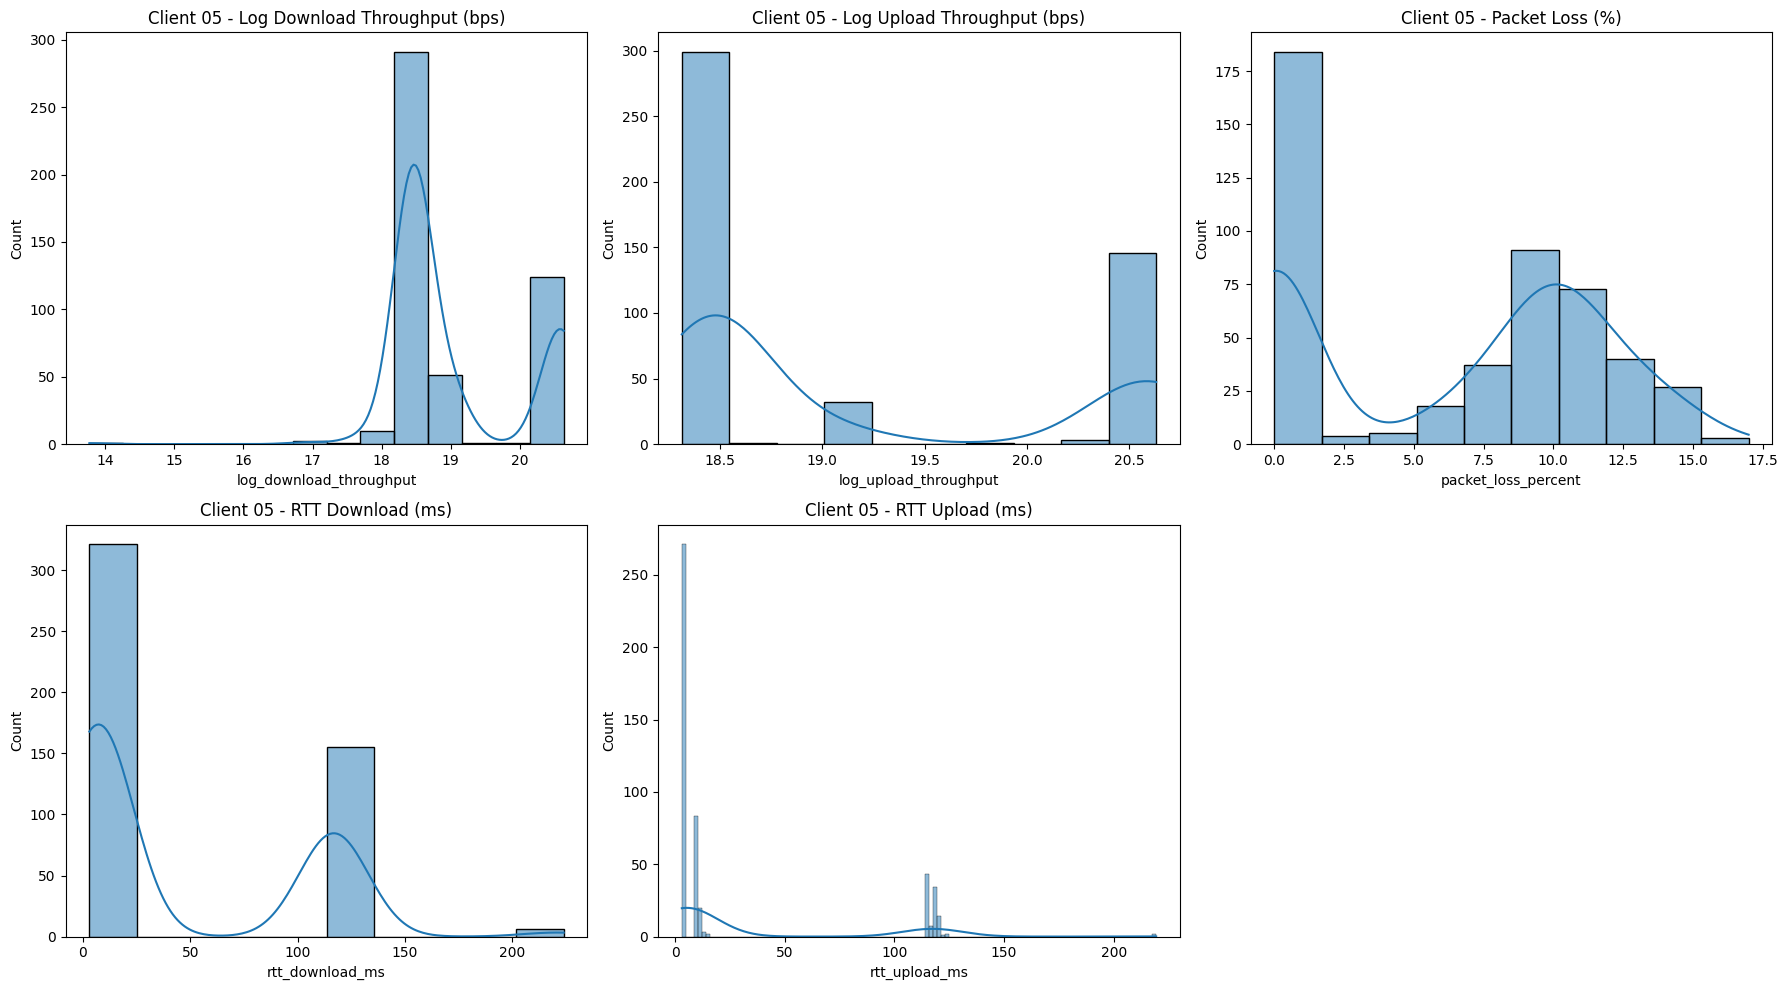

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    bins = np.histogram_bin_edges(client_05[metric], bins='auto')
    sns.histplot(client_05[metric], bins=bins, kde=True, ax=ax, edgecolor='black')
    ax.set_title(f'Client 05 - {plot_info[metric]}')

# Hide any unused subplots
for j in range(len(metrics), 6):
    row = j // 3
    col = j % 3
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()


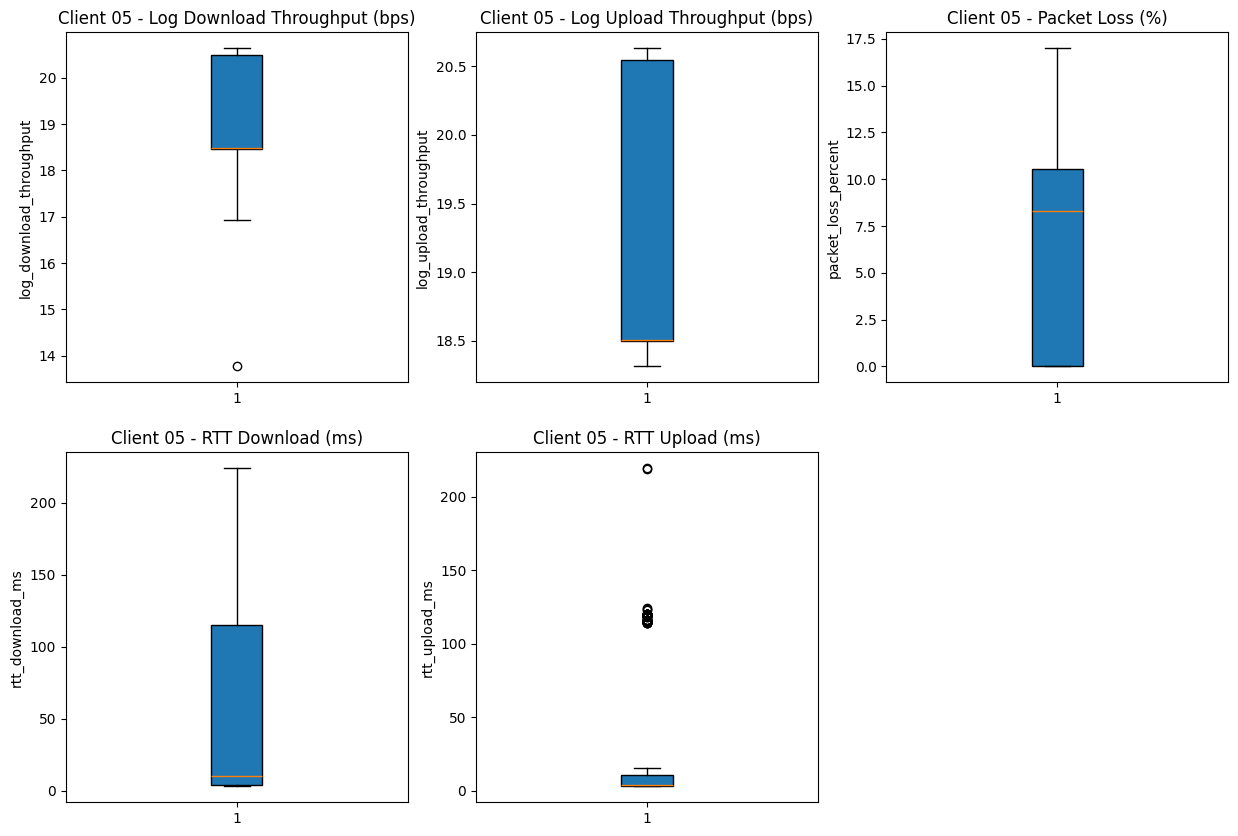

In [201]:
plt.figure(figsize=(15, 10))
for idx, i in enumerate(metrics):
    plt.subplot(2, 3, idx + 1)
    plt.boxplot(client_05[i], vert=True, patch_artist=True)
    plt.title(f'Client 05 - {plot_info[i]}')
    plt.ylabel(i)

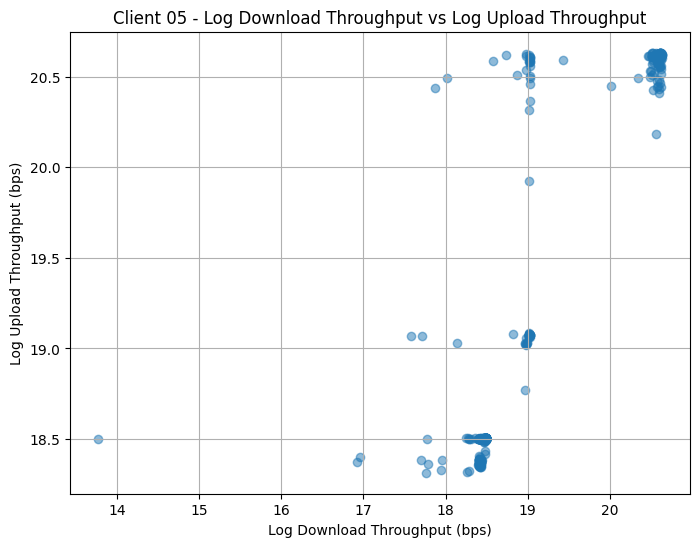

In [202]:
plt.figure(figsize=(8, 6))
plt.scatter(client_05['log_download_throughput'], client_05['log_upload_throughput'], alpha=0.5)
plt.title('Client 05 - Log Download Throughput vs Log Upload Throughput')
plt.xlabel('Log Download Throughput (bps)')
plt.ylabel('Log Upload Throughput (bps)')
plt.grid(True)
plt.show()


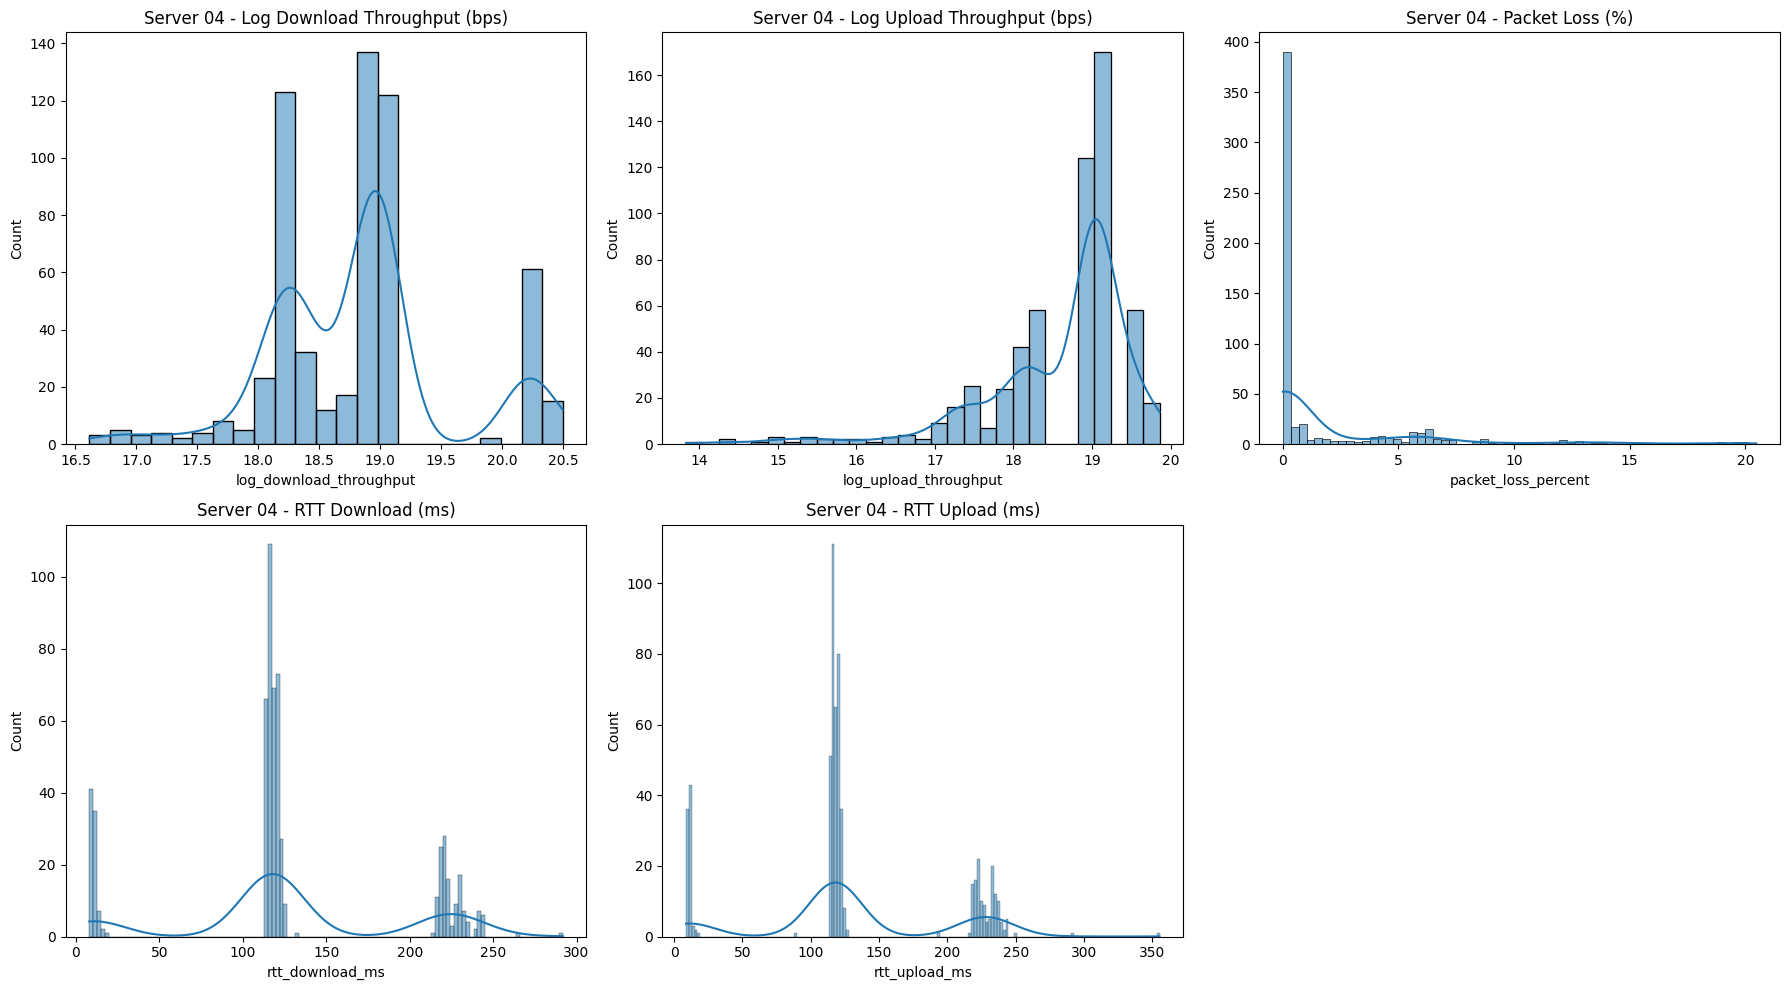

In [203]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    bins = np.histogram_bin_edges(server_04[metric], bins='auto')
    sns.histplot(server_04[metric], bins=bins, kde=True, ax=ax, edgecolor='black')
    ax.set_title(f'Server 04 - {plot_info[metric]}')

# Hide any unused subplots
for j in range(len(metrics), 6):
    row = j // 3
    col = j % 3
    axes[row, col].set_visible(False)
plt.tight_layout()
plt.show()

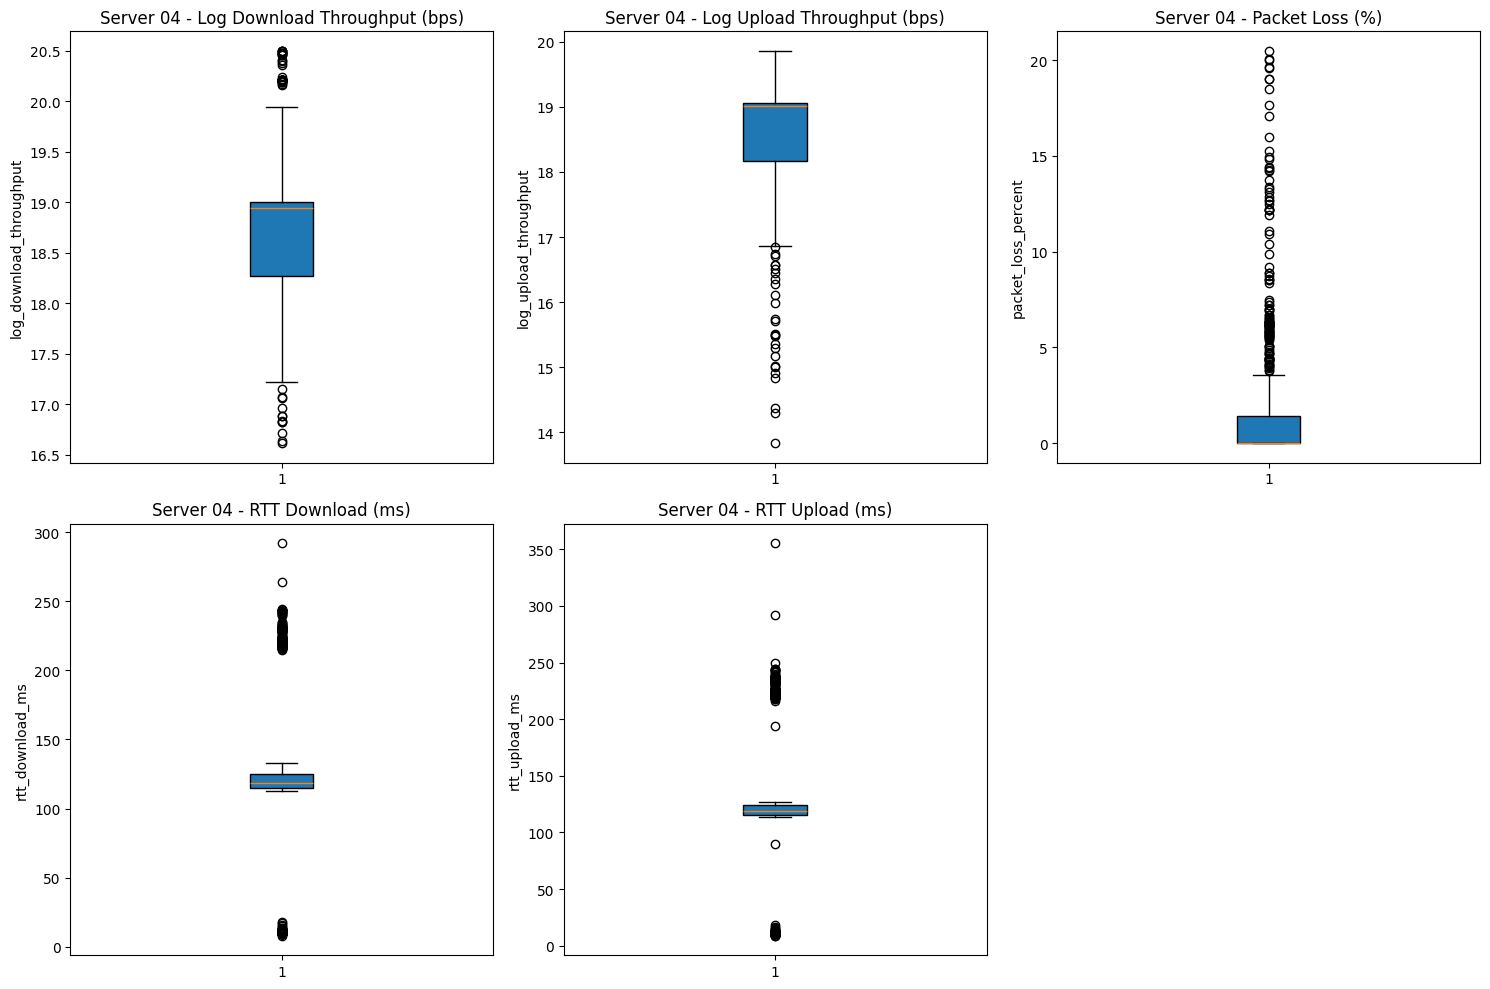

In [204]:
plt.figure(figsize=(15, 10))
for idx, i in enumerate(metrics):
    plt.subplot(2, 3, idx + 1)
    plt.boxplot(server_04[i], vert=True, patch_artist=True)
    plt.title(f'Server 04 - {plot_info[i]}')
    plt.ylabel(i)
plt.tight_layout()
plt.show()

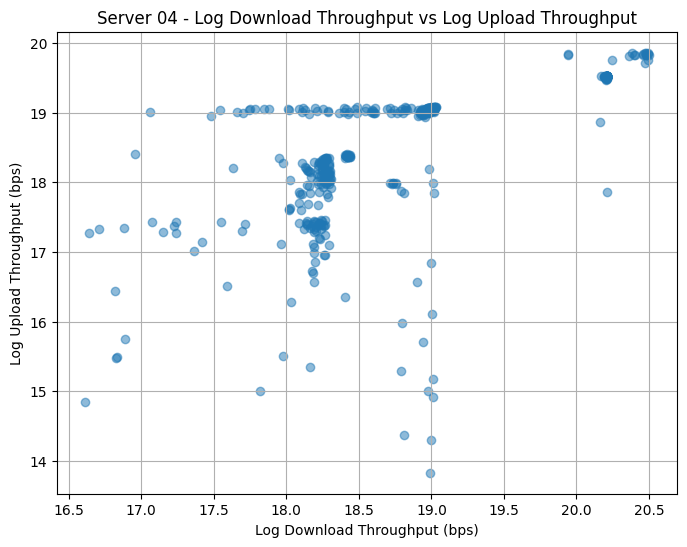

In [205]:
plt.figure(figsize=(8, 6))
plt.scatter(server_04['log_download_throughput'], server_04['log_upload_throughput'], alpha=0.5)
plt.title('Server 04 - Log Download Throughput vs Log Upload Throughput')
plt.xlabel('Log Download Throughput (bps)')
plt.ylabel('Log Upload Throughput (bps)')
plt.grid(True)
plt.show()

# 3.2 MLE

For each metric, we fitted the suggested statistical models using Maximum Likelihood Estimation (MLE) to estimate the parameters that best describe the observed data.

For `rtt_download_ms` and `rtt_upload_ms`, we fitted a Normal distribution and estimated the mean (μ) and variance (σ²).

For `packet_loss_percent`, we fitted a Beta distribution and estimated the shape parameters (α, β).

For `log_download_throughput` and `log_upload_throughput`, we fitted a Gamma distribution and estimated the shape (k) and rate (β) parameters.


In [206]:
server_04_params = {}
client_05_params = {}

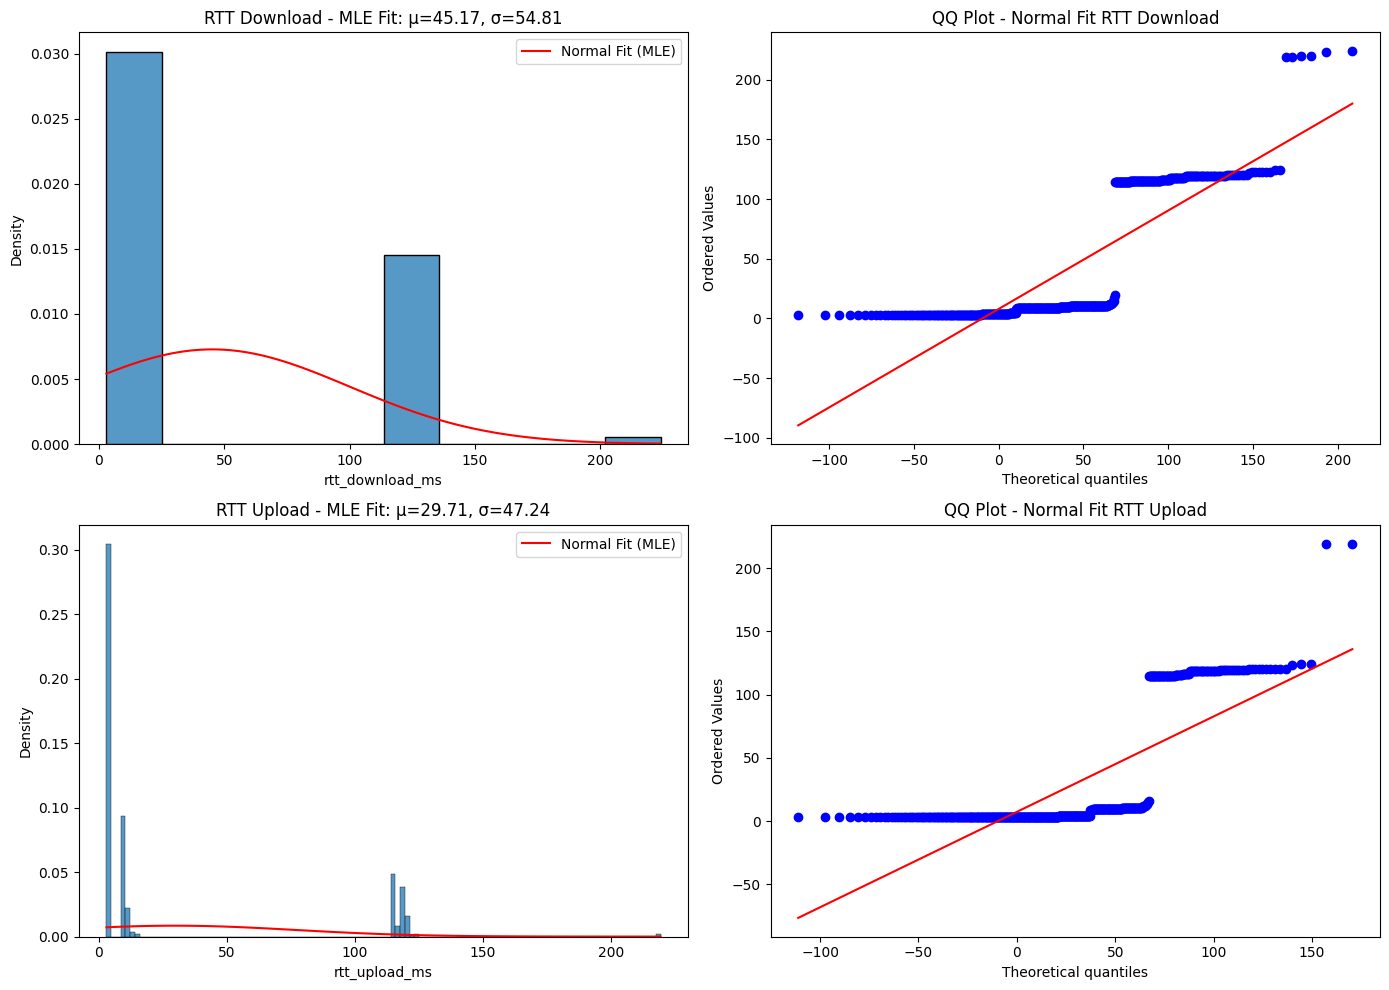

In [207]:
data_download = client_05['rtt_download_ms']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

mu_mle_download, sigma_mle_download = plot_normal_fit(
    data_download, 'RTT Download', axes[0, 0], axes[0, 1]
)

data_upload = client_05['rtt_upload_ms']
mu_mle_upload, sigma_mle_upload = plot_normal_fit(
    data_upload, 'RTT Upload', axes[1, 0], axes[1, 1]
)

client_05_params['rtt_download_ms'] = {'mu_mle': mu_mle_download, 'sigma_mle': sigma_mle_download}
client_05_params['rtt_upload_ms'] = {'mu_mle': mu_mle_upload, 'sigma_mle': sigma_mle_upload}

plt.tight_layout()
plt.show()

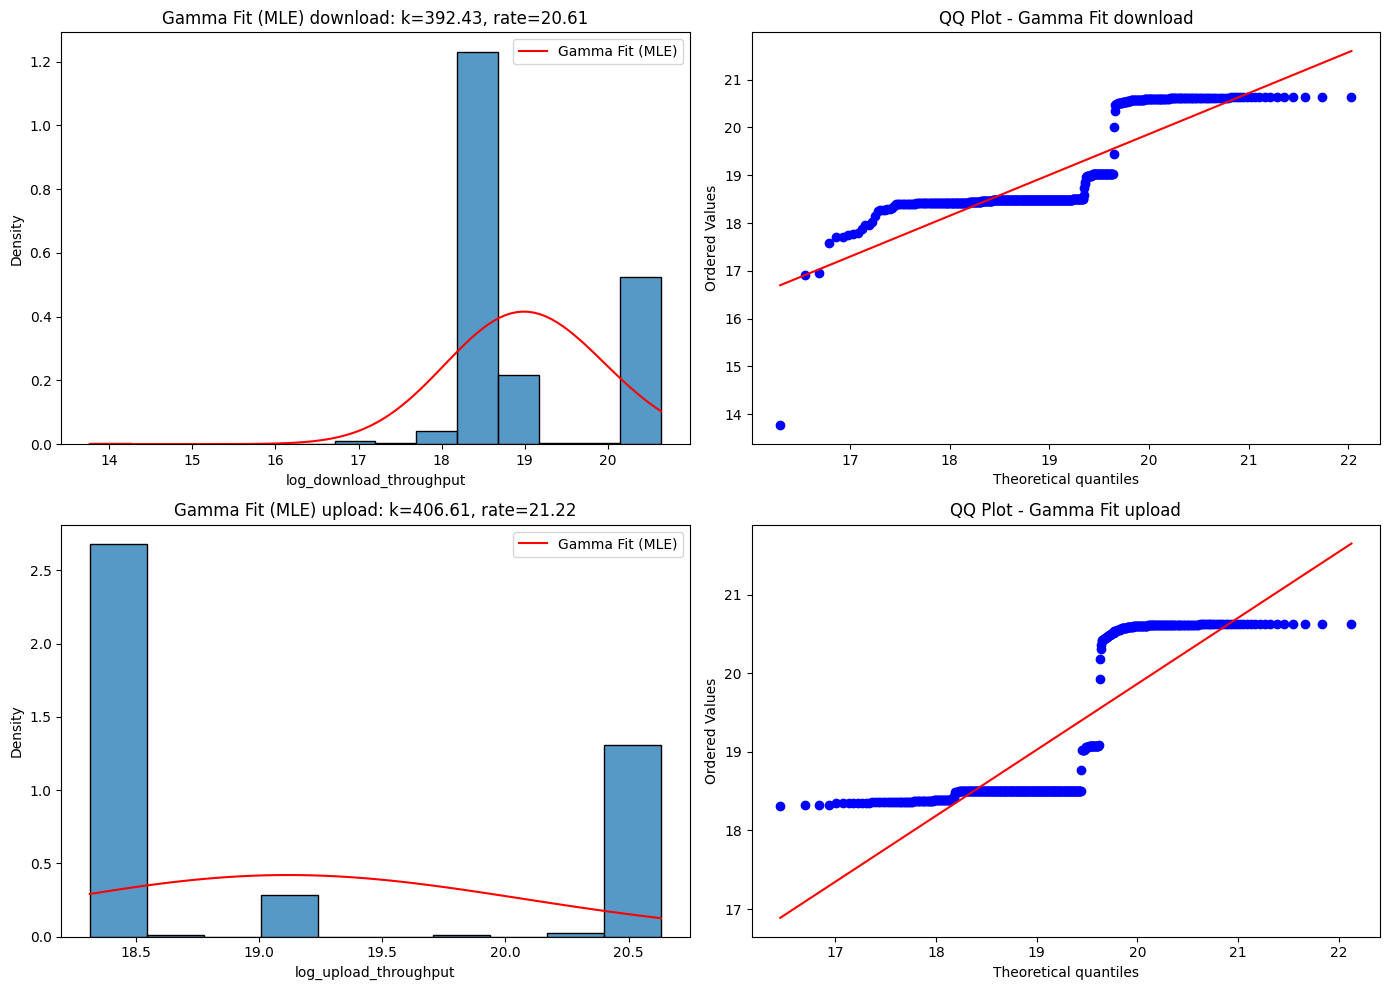

In [208]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

data_download = client_05['log_download_throughput']
shape_download, loc_download, scale_download, rate_download = plot_gamma_fit(
    data_download, 'download', axes[0, 0], axes[0, 1]
)

data_upload = client_05['log_upload_throughput']
shape_upload, loc_upload, scale_upload, rate_upload = plot_gamma_fit(
    data_upload, 'upload', axes[1, 0], axes[1, 1]
)

# store parameters
client_05_params["log_download_throughput"] = {
    "shape_mle": shape_download,
    "loc_mle": loc_download,
    "scale_mle": scale_download,
    "rate_mle": rate_download
}

client_05_params["log_upload_throughput"] = {
    "shape_mle": shape_upload,
    "loc_mle": loc_upload,
    "scale_mle": scale_upload,
    "rate_mle": rate_upload
}

plt.tight_layout()
plt.show()

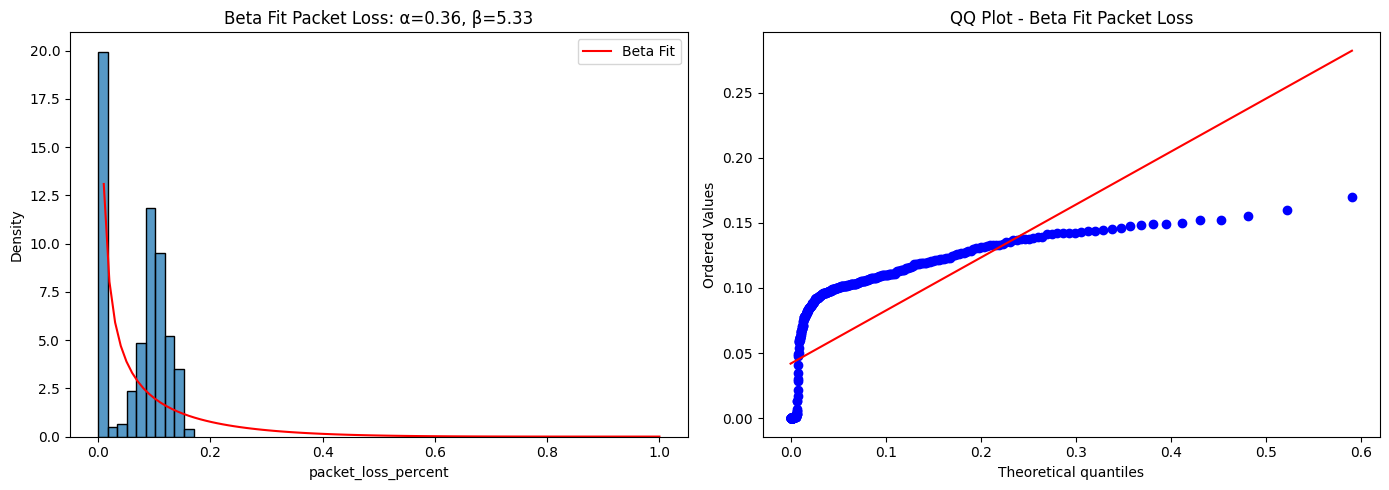

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

data = client_05['packet_loss_percent'] / 100  # converter para [0,1]
data = data[data > 0]  # evitar zeros exatos

a_mle, b_mle, loc_mle, scale_mle = plot_beta_fit(
    data, 'Packet Loss', axes[0], axes[1]
)

client_05_params['packet_loss_percent'] = {
    'a_mle': a_mle, 'b_mle': b_mle, 'loc_mle': loc_mle, 'scale_mle': scale_mle
}

plt.tight_layout()
plt.show()

## servidor

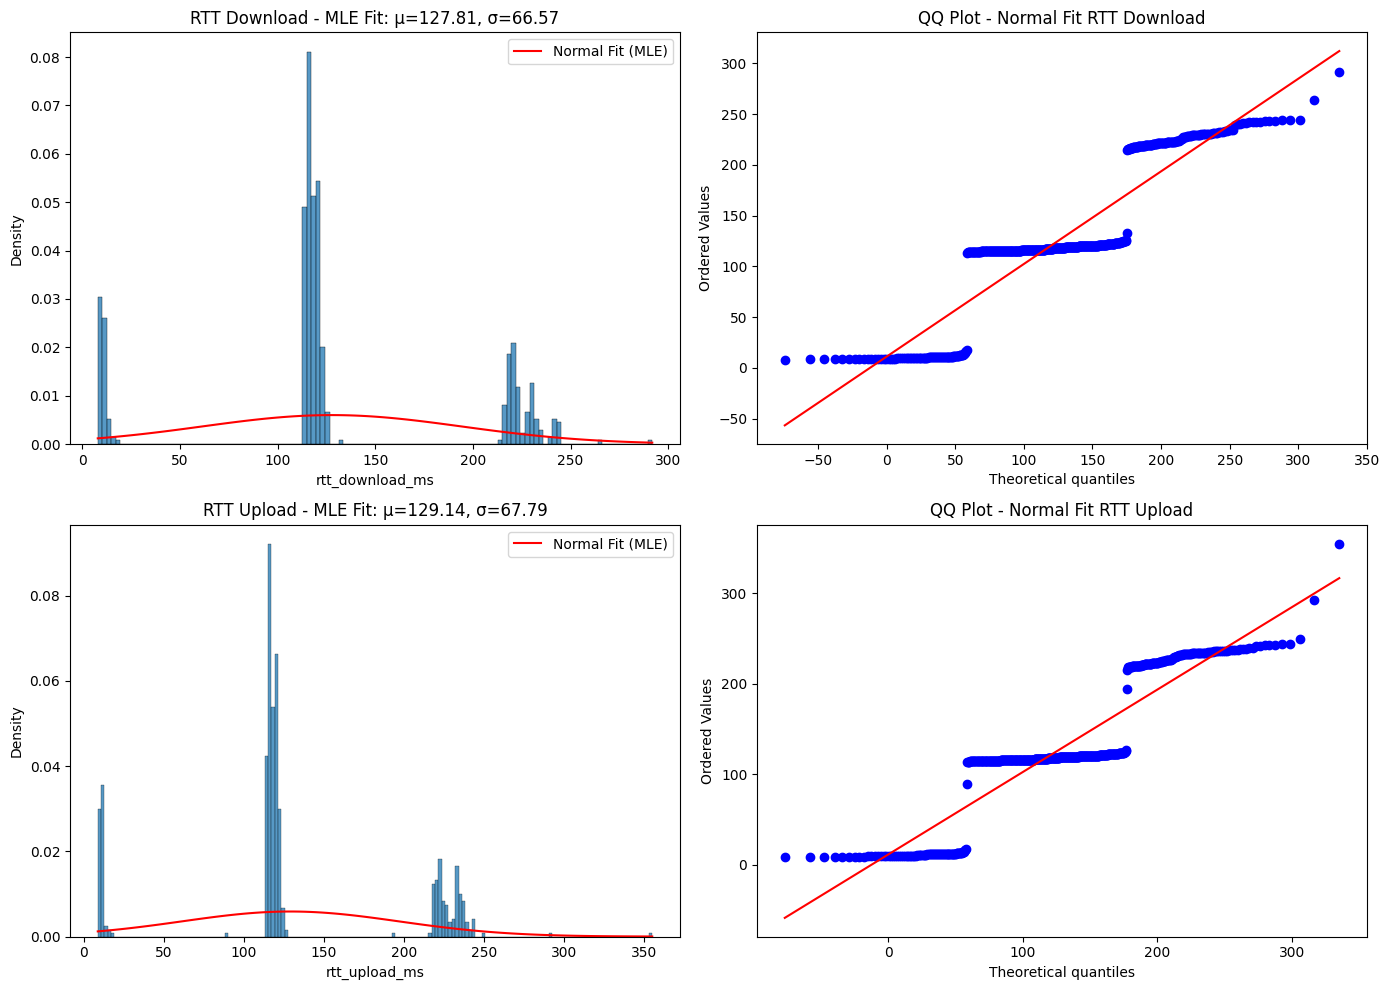

In [210]:
data_download = server_04['rtt_download_ms']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

mu_mle_download, sigma_mle_download = plot_normal_fit(
    data_download, 'RTT Download', axes[0, 0], axes[0, 1]
)

data_upload = server_04['rtt_upload_ms']
mu_mle_upload, sigma_mle_upload = plot_normal_fit(
    data_upload, 'RTT Upload', axes[1, 0], axes[1, 1]
)

server_04_params['rtt_download_ms'] = {'mu_mle': mu_mle_download, 'sigma_mle': sigma_mle_download}
server_04_params['rtt_upload_ms'] = {'mu_mle': mu_mle_upload, 'sigma_mle': sigma_mle_upload}

plt.tight_layout()
plt.show()

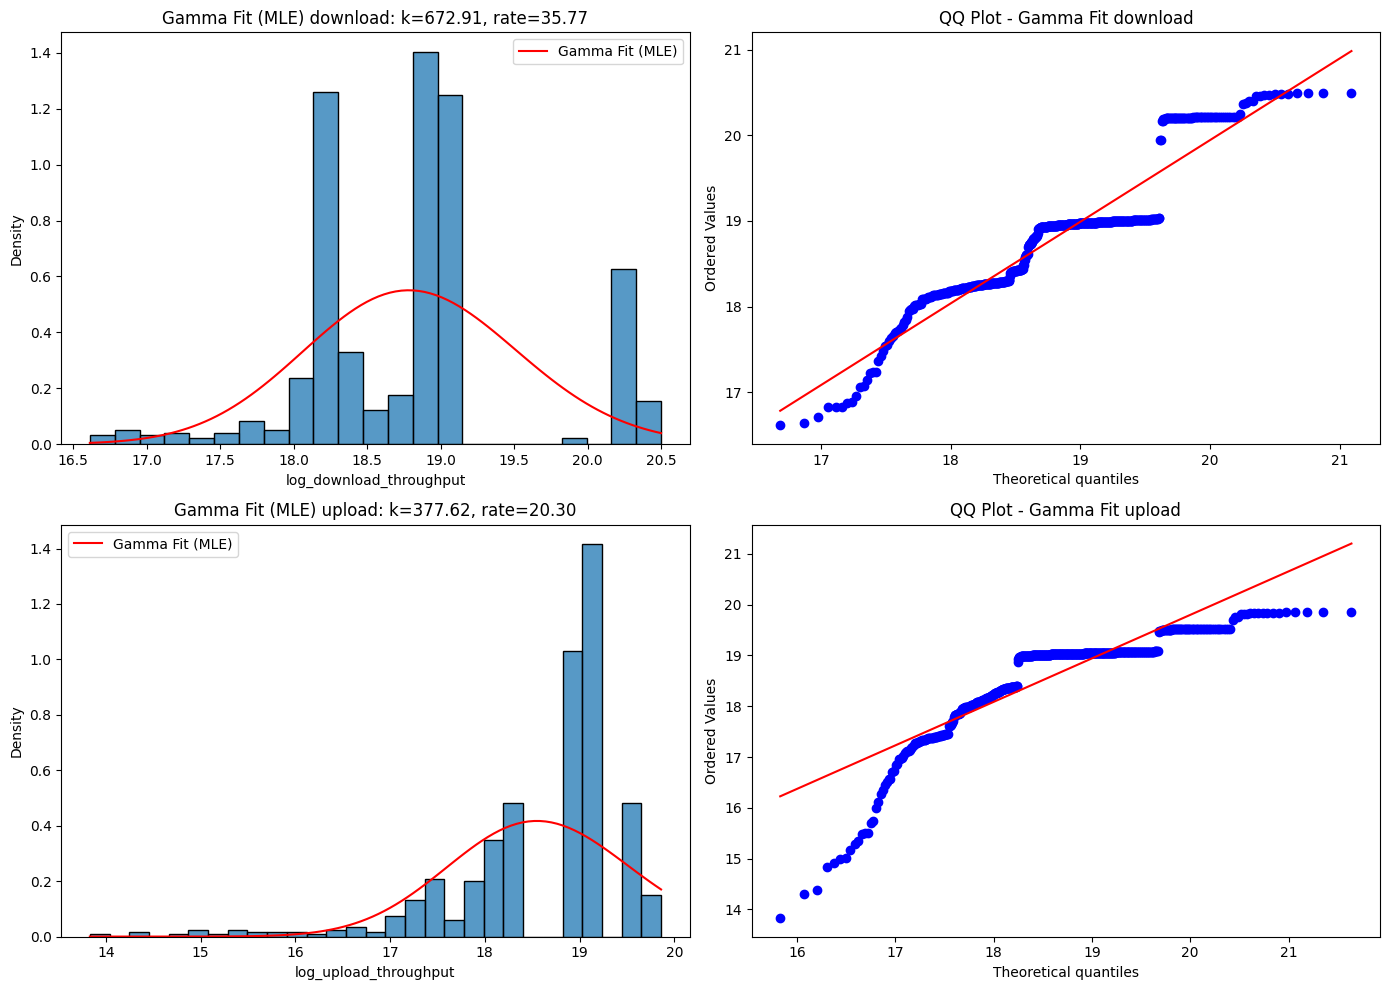

In [211]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

data_download = server_04['log_download_throughput']
shape_download, loc_download, scale_download, rate_download = plot_gamma_fit(
    data_download, 'download', axes[0, 0], axes[0, 1]
)

data_upload = server_04['log_upload_throughput']
shape_upload, loc_upload, scale_upload, rate_upload = plot_gamma_fit(
    data_upload, 'upload', axes[1, 0], axes[1, 1]
)

# store parameters
server_04_params["log_download_throughput"] = {
    "shape_mle": shape_download,
    "loc_mle": loc_download,
    "scale_mle": scale_download,
    "rate_mle": rate_download
}

server_04_params["log_upload_throughput"] = {
    "shape_mle": shape_upload,
    "loc_mle": loc_upload,
    "scale_mle": scale_upload,
    "rate_mle": rate_upload
}

plt.tight_layout()
plt.show()

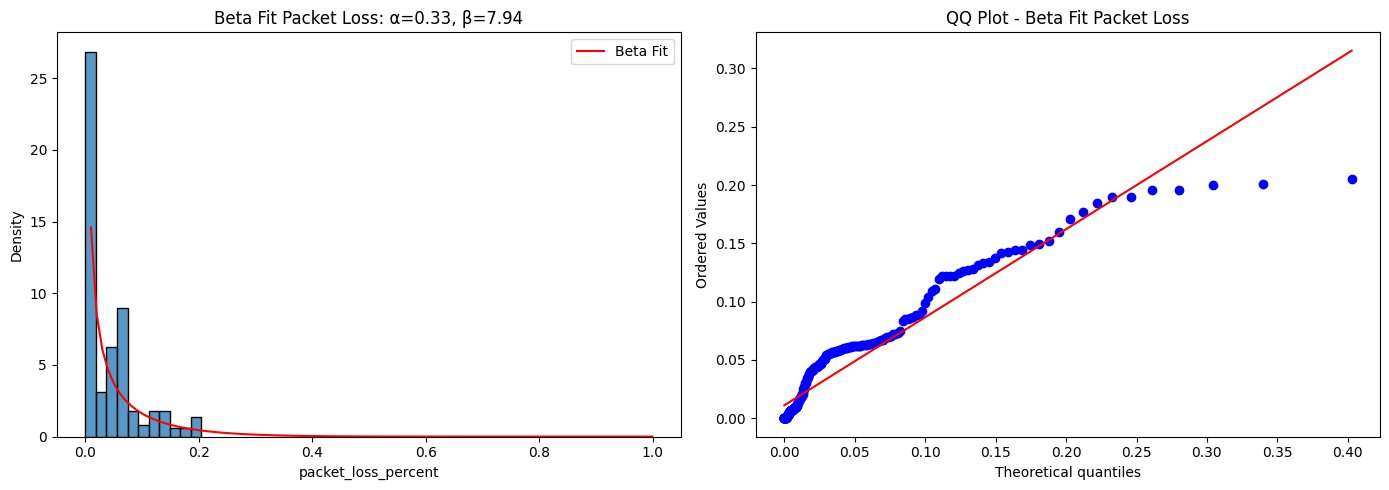

In [212]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

data = server_04['packet_loss_percent'] / 100  # converter para [0,1]
data = data[data > 0]  # evitar zeros exatos

a_mle, b_mle, loc_mle, scale_mle = plot_beta_fit(
    data, 'Packet Loss', axes[0], axes[1]
)

server_04_params['packet_loss_percent'] = {
    'a_mle': a_mle, 'b_mle': b_mle, 'loc_mle': loc_mle, 'scale_mle': scale_mle
}

plt.tight_layout()
plt.show()

# Inferência Bayesiana

Para cada métrica e conjunto de dados (client_05 e server_04):
- Normal (RTT): especificar priors para μ e σ²
- Gamma (throughput): especificar priors para shape (k) e rate (β)
- Beta (packet loss): especificar priors para α e β

## Dividindo os dados emconjuntos de treino e teste

In [213]:
train_client05, test_client05 = train_test_split(client_05, test_size=0.3, random_state=42)
train_server04, test_server04 = train_test_split(server_04, test_size=0.3, random_state=42)

## Definição das priors

Utilizaremos priors não informativas ou fracas para refletir a falta de conhecimento prévio sobre os parâmetros.

In [214]:
priors = {
    'rtt_download_ms': {'mu': 0, 'sigma': 1000},
    'rtt_upload_ms': {'mu': 0, 'sigma': 1000},
    'log_download_throughput': {'shape': 1, 'rate': 1},
    'log_upload_throughput': {'shape': 1, 'rate': 1},
    'packet_loss_percent': {'a': 1, 'b': 1}
}

In [215]:
client05_posteriors = {}
for metric in ['rtt_download_ms', 'rtt_upload_ms']:
    data = train_client05[metric]
    prior = priors[metric]
    posterior = inferencia_bayes_normal(
        data,
        mu_0=prior['mu'],
        tau_0_sq=prior['sigma']**2,
        sigma_sq=client_05_params[metric]['sigma_mle']**2
    )
    client05_posteriors[metric] = posterior

for metric in ['log_download_throughput', 'log_upload_throughput']:
    data = train_client05[metric]
    prior = priors[metric]
    posterior = inferencia_bayes_gamma(
        data,
        k_mle=client_05_params[metric]['shape_mle'],
        a_0=prior['shape'],
        b_0=1/prior['rate']
    )
    client05_posteriors[metric] = posterior

data = train_client05['packet_loss_percent'] / 100
prior = priors['packet_loss_percent']
posterior = inferencia_bayes_beta(
    data,
    a_0=prior['a'],
    b_0=prior['b'],
    n=1000
)
client05_posteriors['packet_loss_percent'] = posterior


In [216]:
for metric in client05_posteriors:
    print(f"Client 05 - {metric} Posterior:")
    for key, value in client05_posteriors[metric].items():
        print(f"  {key}: {value}")
    print("\n")

Client 05 - rtt_download_ms Posterior:
  posterior_mu_n: 45.948439094047494
  posterior_tau_n_sq: 8.913621403863074
  predictive_mean: 45.948439094047494
  predictive_var: 3012.830810286269


Client 05 - rtt_upload_ms Posterior:
  posterior_mu_n: 29.96057907096581
  posterior_tau_n_sq: 6.621226893793451
  predictive_mean: 29.96057907096581
  predictive_var: 2237.989464497571


Client 05 - log_download_throughput Posterior:
  posterior_a_n: 132250.2254434611
  posterior_b_n: 6399.2145401089165
  predictive_mean: 18.988767181332097
  predictive_var: 0.9215531468639163


Client 05 - log_upload_throughput Posterior:
  posterior_a_n: 137027.4565060274
  posterior_b_n: 6444.8751341591815
  predictive_mean: 19.124258558335853
  predictive_var: 0.9021622613738055


Client 05 - packet_loss_percent Posterior:
  posterior_a_n: 22025
  posterior_b_n: 314977
  predictive_mean: 0.065355695218426
  predictive_var: 1.812575209150726e-07




In [217]:
df_client05_results = pd.DataFrame(columns=[
    'metric', 'test_mean', 'test_var', 'pred_mean', 'pred_var', 'mean_error_percentage_difference'
])

for metric in client05_posteriors:
    test_data = test_client05[metric]
    if metric == 'packet_loss_percent':
        test_data = test_data / 100  # converter para [0,1]

    test_mean = np.mean(test_data)
    test_var = np.var(test_data, ddof=1)

    pred_mean = client05_posteriors[metric]['predictive_mean']
    pred_var = client05_posteriors[metric]['predictive_var']
    mean_error_percentage_difference = abs(pred_mean - test_mean) / test_mean * 100 if test_mean != 0 else np.nan

    df_client05_results = pd.concat([
        df_client05_results,
        pd.DataFrame([{
            'metric': metric,
            'test_mean': test_mean,
            'pred_mean': pred_mean,
            'test_var': test_var,
            'pred_var': pred_var,
            'mean_error_percentage_difference': mean_error_percentage_difference
        }])
    ], ignore_index=True)

df_client05_results.to_csv('client05_test_vs_predictive_results.csv', index=False)
print("Client 05 - Test Results vs Predictive Posterior:")
display(df_client05_results)


Client 05 - Test Results vs Predictive Posterior:


/var/folders/gk/45zlhqq53hb1zpvjp5r1ww2h0000gn/T/ipykernel_76576/389674838.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_client05_results = pd.concat([


,metric,test_mean,test_var,pred_mean,pred_var,mean_error_percentage_difference
0,rtt_download_ms,43.347586,3020.783540,45.948439,3.012831e+03,5.999995
1,rtt_upload_ms,29.116786,2131.784531,29.960579,2.237989e+03,2.897960
2,log_download_throughput,19.160377,0.959520,18.988767,9.215531e-01,0.895651
3,log_upload_throughput,19.267489,0.983408,19.124259,9.021623e-01,0.743378
4,packet_loss_percent,0.057832,0.003001,0.065356,1.812575e-07,13.009703


In [218]:
server04_posteriors = {}
for metric in ['rtt_download_ms', 'rtt_upload_ms']:
    data = train_server04[metric]
    prior = priors[metric]
    posterior = inferencia_bayes_normal(
        data,
        mu_0=prior['mu'],
        tau_0_sq=prior['sigma']**2,
        sigma_sq=server_04_params[metric]['sigma_mle']**2
    )
    server04_posteriors[metric] = posterior
for metric in ['log_download_throughput', 'log_upload_throughput']:
    data = train_server04[metric]
    prior = priors[metric]
    posterior = inferencia_bayes_gamma(
        data,
        k_mle=server_04_params[metric]['shape_mle'],
        a_0=prior['shape'],
        b_0=1/prior['rate']
    )
    server04_posteriors[metric] = posterior
data = train_server04['packet_loss_percent'] / 100
prior = priors['packet_loss_percent']
posterior = inferencia_bayes_beta(
    data,
    a_0=prior['a'],
    b_0=prior['b'],
    n=1000
)
server04_posteriors['packet_loss_percent'] = posterior


In [219]:
for metric in server04_posteriors:
    print(f"Server 04 - {metric} Posterior:")
    for key, value in server04_posteriors[metric].items():
        print(f"  {key}: {value}")
    print("\n")

Server 04 - rtt_download_ms Posterior:
  posterior_mu_n: 127.90613175348933
  posterior_tau_n_sq: 10.968079244046196
  predictive_mean: 127.90613175348933
  predictive_var: 4442.120695071742


Server 04 - rtt_upload_ms Posterior:
  posterior_mu_n: 128.96190171580741
  posterior_tau_n_sq: 11.37606816000118
  predictive_mean: 128.96190171580741
  predictive_var: 4607.359889025687


Server 04 - log_download_throughput Posterior:
  posterior_a_n: 271855.90355163335
  posterior_b_n: 7596.582611283952
  predictive_mean: 18.803422305158296
  predictive_var: 0.5267363011367732


Server 04 - log_upload_throughput Posterior:
  posterior_a_n: 152559.00460556019
  posterior_b_n: 7511.848889000052
  predictive_mean: 18.59368536881201
  predictive_var: 0.9178121993004718


Server 04 - packet_loss_percent Posterior:
  posterior_a_n: 7426
  posterior_b_n: 396576
  predictive_mean: 0.018381097123281568
  predictive_var: 4.4661134674311966e-08




In [220]:
df_server04_results = pd.DataFrame(columns=[
    'metric', 'test_mean', 'test_var', 'pred_mean', 'pred_var', 'mean_error_percentage_difference'
])

for metric in server04_posteriors:
    test_data = test_server04[metric]
    if metric == 'packet_loss_percent':
        test_data = test_data / 100  # converter para [0,1]

    test_mean = np.mean(test_data)
    test_var = np.var(test_data, ddof=1)

    pred_mean = server04_posteriors[metric]['predictive_mean']
    pred_var = server04_posteriors[metric]['predictive_var']
    mean_error_percentage_difference = abs(pred_mean - test_mean) / test_mean * 100 if test_mean != 0 else np.nan

    df_server04_results = pd.concat([
        df_server04_results,
        pd.DataFrame([{
            'metric': metric,
            'test_mean': test_mean,
            'pred_mean': pred_mean,
            'test_var': test_var,
            'pred_var': pred_var,
            'mean_error_percentage_difference': mean_error_percentage_difference
        }])
    ], ignore_index=True)

#save to csv
df_server04_results.to_csv('server04_test_vs_predictive.csv', index=False)
print("Server 04 - Test Results vs Predictive Posterior:")
display(df_server04_results)


Server 04 - Test Results vs Predictive Posterior:


/var/folders/gk/45zlhqq53hb1zpvjp5r1ww2h0000gn/T/ipykernel_76576/838369162.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_server04_results = pd.concat([


,metric,test_mean,test_var,pred_mean,pred_var,mean_error_percentage_difference
0,rtt_download_ms,127.582529,4604.122328,127.906132,4.442121e+03,0.253642
1,rtt_upload_ms,129.549638,4860.065525,128.961902,4.607360e+03,0.453676
2,log_download_throughput,18.834585,0.505475,18.803422,5.267363e-01,0.165456
3,log_upload_throughput,18.617749,0.716771,18.593685,9.178122e-01,0.129249
4,packet_loss_percent,0.021870,0.001873,0.018381,4.466113e-08,15.952431


In [221]:
df_client05_comparison = compare_bayes_mle(client_05_params, client05_posteriors)
df_client05_comparison.to_csv('client05_bayes_mle_comparison.csv', index=False)
display(df_client05_comparison)

,metric,mle_mean,mle_var,bayes_mean,bayes_var,mean_error_percentage_difference
0,rtt_download_ms,45.166311,3003.917189,45.948439,3.012831e+03,1.731662
1,rtt_upload_ms,29.706880,2231.368238,29.960579,2.237989e+03,0.854009
2,log_download_throughput,19.038318,0.923621,18.988767,9.215531e-01,0.260269
3,log_upload_throughput,19.165272,0.903349,19.124259,9.021623e-01,0.213998
4,packet_loss_percent,0.063033,0.008836,0.065356,1.812575e-07,3.684459


In [222]:
df_server04_comparison = compare_bayes_mle(server_04_params, server04_posteriors)
df_server04_comparison.to_csv('server04_bayes_mle_comparison.csv', index=False)
display(df_server04_comparison)

,metric,mle_mean,mle_var,bayes_mean,bayes_var,mean_error_percentage_difference
0,rtt_download_ms,127.809696,4431.152616,127.906132,4.442121e+03,0.075453
1,rtt_upload_ms,129.139858,4595.983821,128.961902,4.607360e+03,0.137801
2,log_download_throughput,18.811073,0.525861,18.803422,5.267363e-01,0.040674
3,log_upload_throughput,18.599199,0.916083,18.593685,9.178122e-01,0.029646
4,packet_loss_percent,0.039566,0.004101,0.018381,4.466113e-08,53.542955


--------------------------

# SEGUNDA PARTE DO TRABALHO: TESTE DE HIPÓTESE


Para as variáveis de throughput (download e upload) e RTT (download e upload), realizamos testes de hipótese para comparar as distribuições entre os conjuntos de dados client_05 e server_04.

Para isso, começaremos definindo as hipóteses nula e alternativa para cada métrica:
- Hipótese Nula (H0): As distribuições das métricas são iguais entre client_05 e server_04.
- Hipótese Alternativa (H1): As distribuições das métricas são diferentes entre client_05 e server_04.

Para calcular a verossimilhança sob H0, combinamos os dados dos dois conjuntos e ajustamos o modelo estatístico apropriado (Normal para RTT e Gamma para throughput) aos dados combinados. Calculamos a verossimilhança dos dados observados sob este modelo combinado.

Para calcular a verossimilhança sob H1, ajustamos o modelo estatístico separadamente para cada conjunto de dados (client_05 e server_04) e calculamos a verossimilhança dos dados observados sob esses modelos separados.



## Calculando a verossimilhança sob H0 e H1 para throughput de download

In [223]:

YA_download_throughput = client_05['download_throughput_bps']
YB_download_throughput = server_04['download_throughput_bps']
Y_download_throughput_concatenado = np.concatenate([YA_download_throughput, YB_download_throughput])

k_download_throughput_chapeu, _, _, _ = fit_gamma_mle(Y_download_throughput_concatenado)
lrt_statistic_download_throughput = lrt_gamma(YA_download_throughput, YB_download_throughput, k_download_throughput_chapeu)
print(f"LRT Statistic for Download Throughput between Client 05 and Server 04: {lrt_statistic_download_throughput:.4f}")


LRT Statistic for Download Throughput between Client 05 and Server 04: 72.7815


## Calculando a verossimilhança sob H0 e H1 para throughput de upload

In [224]:

YA_upload_throughput = client_05['upload_throughput_bps']
YB_upload_throughput = server_04['upload_throughput_bps']
Y_upload_throughput_concatenado = np.concatenate([YA_upload_throughput, YB_upload_throughput])

k_upload_throughput_chapeu, _, _, _ = fit_gamma_mle(Y_upload_throughput_concatenado)
lrt_statistic_upload_throughput = lrt_gamma(YA_upload_throughput, YB_upload_throughput, k_upload_throughput_chapeu)
print(f"LRT Statistic for Upload Throughput between Client 05 and Server 04: {lrt_statistic_upload_throughput:.4f}")


LRT Statistic for Upload Throughput between Client 05 and Server 04: 204.2865


Iremos calcular o p-valor associado ao teste de hipótese utilizando a razão de verossimilhança (LR):
LR = L(H1) / L(H0)

Um p-valor baixo (geralmente < 0.05) indicaria evidências suficientes para rejeitar a hipótese nula em favor da hipótese alternativa, sugerindo que as distribuições das métricas são significativamente diferentes entre os dois conjuntos de dados. Usaremos alpha = 0.05 como nível de significância para nossos testes.

In [225]:
p_value_download_throughput = st.chi2.sf(lrt_statistic_download_throughput, df=1)
p_value_upload_throughput = st.chi2.sf(lrt_statistic_upload_throughput, df=1)

print(f"P-value for Download Throughput LRT: {p_value_download_throughput:.3e}")
print(f"P-value for Upload Throughput LRT: {p_value_upload_throughput:.3e}")

P-value for Download Throughput LRT: 1.448e-17
P-value for Upload Throughput LRT: 2.424e-46


Como p-valor para ambos throughput de download e upload são menores que 0.05, rejeitamos a hipótese nula para ambas as métricas. Isso indica que há evidências suficientes para afirmar que as distribuições de throughput de download e upload são significativamente diferentes entre os conjuntos de dados client_05 e server_04.

## Calculando a verossimilhança sob H0 e H1 para RTT de download

In [226]:

YA_download_rtt = client_05['rtt_download_ms']
YB_download_rtt = server_04['rtt_download_ms']
Y_download_rtt_concatenado = np.concatenate([YA_download_rtt, YB_download_rtt])

sigma2_download_rtt_chapeu = np.mean((Y_download_rtt_concatenado - np.mean(Y_download_rtt_concatenado))**2)

lrt_statistic_download_rtt = lrt_normal(YA_download_rtt, YB_download_rtt, sigma2_download_rtt_chapeu)
print(f"LRT Statistic for Download RTT between Client 05 and Server 04: {lrt_statistic_download_rtt:.4f}")


LRT Statistic for Download RTT between Client 05 and Server 04: 327.8311


In [227]:

YA_upload_rtt = client_05['rtt_upload_ms']
YB_upload_rtt = server_04['rtt_upload_ms']
Y_upload_rtt_concatenado = np.concatenate([YA_upload_rtt, YB_upload_rtt])

sigma2_upload_rtt_chapeu = np.mean((Y_upload_rtt_concatenado - np.mean(Y_upload_rtt_concatenado))**2)

lrt_statistic_upload_rtt = lrt_normal(YA_upload_rtt, YB_upload_rtt, sigma2_upload_rtt_chapeu)
print(f"LRT Statistic for upload RTT between Client 05 and Server 04: {lrt_statistic_upload_rtt:.4f}")


LRT Statistic for upload RTT between Client 05 and Server 04: 435.1059


In [228]:
p_value_download_rtt = st.chi2.sf(lrt_statistic_download_rtt, df=1)
p_value_upload_rtt = st.chi2.sf(lrt_statistic_upload_rtt, df=1)

print(f"P-value for Download Throughput LRT: {p_value_download_rtt:.3e}")
print(f"P-value for Upload Throughput LRT: {p_value_upload_rtt:.3e}")

P-value for Download Throughput LRT: 2.852e-73
P-value for Upload Throughput LRT: 1.258e-96


Novamente, como os p-valores para RTT de download e upload são menores que 0.05, rejeitamos a hipótese nula para ambas as métricas. Isso sugere que as distribuições de RTT de download e upload também são significativamente diferentes entre os conjuntos de dados client_05 e server_04.